<h1 style='color: green; font-size: 26px; font-weight: bold;'> 3. Previsão de falha <h1>

### Notebook 2
1.  Pré Processamento II
2. Feature engineering
3. Modelagem
4. Avaliação
5. Modelo final
6. Conclusão.

<strong>Descripción</strong>
<p>Los galpones de Full de mercado libre cuentan con una flota de dispositivos que transmiten
diariamente telemetría agregada en varios atributos.
Las técnicas de mantenimiento predictivo están diseñadas para ayudar a determinar la
condición del equipo de mantenimiento en servicio para predecir cuándo se debe realizar el
mantenimiento. Este enfoque promete ahorros de costos sobre el mantenimiento preventivo
de rutina o basado en el tiempo porque las tareas se realizan solo cuando están justificadas.
</p>

<strong>Entregable</strong>
<p>Tiene la tarea de generar una Jupyter notebook con un modelo predictivo para predecir la
probabilidad de falla del dispositivo con el objetivo de bajar los costos del proceso. Como
una referencia, una falla de un dispositivo tiene un costo de 1 mientras el costo de un
mantenimiento es 0,5. El archivo "full_devices.csv" tiene los valores diários para los 9
atributos de los dispositivos y la columna que está tratando de predecir se llama 'failure' con
el valor binario 0 para no fallar y 1 para fallar
</p>

# Carregando os dados

In [229]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

In [230]:
dir_data = "F:\PycharmProjects\DesaioMELI\data"
df = pd.read_csv(dir_data+r'\full_devices.csv', sep=',', encoding='ISO-8859-1')
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


coluna 'failure'
1 = Equipamento falhou
0 = Equipamento não falhou

'device'
equipamento monitorado

'attribute1'
pode ser algum código, não tenho certeza.


In [231]:
df.nunique()

date             304
device          1169
failure            2
attribute1    123877
attribute2       558
attribute3        47
attribute4       115
attribute5        60
attribute6     44838
attribute7        28
attribute8        28
attribute9        65
dtype: int64

In [232]:
df.groupby(['device']).agg(['count']).shape

(1169, 11)

In [233]:
df.groupby(['date']).agg(['count']).shape

(304, 11)

# Pré processamento II

In [234]:
#Tranformando os tipos de dados
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   attribute1  124494 non-null  int64         
 4   attribute2  124494 non-null  int64         
 5   attribute3  124494 non-null  int64         
 6   attribute4  124494 non-null  int64         
 7   attribute5  124494 non-null  int64         
 8   attribute6  124494 non-null  int64         
 9   attribute7  124494 non-null  int64         
 10  attribute8  124494 non-null  int64         
 11  attribute9  124494 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [235]:
df = df.drop_duplicates()

Eliminando o registro duplicado identificado no notebook 1

In [236]:
df.shape

(124493, 12)

In [237]:
df.groupby(['failure'])['device'].count()

failure
0    124387
1       106
Name: device, dtype: int64

In [238]:
#percentual de falha em 11 meses
print('Percentual de falha: {:.5f}%'.format(df.groupby(['failure'])['device'].count().iloc[1] / df['device'].count()))

Percentual de falha: 0.00085%


In [239]:
#ordenando o dataset por data e pelo device para posteriormente verificar o histórico até a falha
df = df.sort_values(by=['device','date'], ascending=[True, True])
df['flipper'] = np.where((df.device != df.device.shift(1)), 1, 0)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,flipper
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,0
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,0
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,0
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,0


<strong>Pensando no oversampling, somente duplicar os dados pode gerar overfitting, pois existe um tempo de vida para cada dispositivo e um período de uso para falha, visto que não é um evento comum, então introduzir somente os registros de falhas, sem considerar os dados que antecem o evento resultará em um viés que acarretará em overfitting. O viés é inevitavél, mas o ideal é que acompanhe o comportamento dos dados.</strong>

Dito isso, vou criar algumas features para obter essa informação de comportamento dos dados até a falha e com isso gerar os novos registros, além de tranformar os dados de colunas para melhor se adequarem a modelagem.

In [240]:
#pega o 1º registro para cada dispositivo, com a coluna criada 'flipper'
starter = df[df['flipper'] == 1]
starter = starter[['date','device']]
starter = starter.rename(index=str, columns={"date": "start_date"})
starter['start_date'] = pd.to_datetime(starter['start_date'])

In [241]:
#Merge start_date com o dataset original, para marcar a data de inicio de monitoramento de cada dispositivo
df = df.sort_values(by=['device', 'date'], ascending=[True, True])
starter = starter.sort_values(by=['device'], ascending=[True])
df = df.merge(starter, on=['device'], how='left')

In [242]:
df[df['failure'] == 1].groupby(['date','start_date'])['device'].count()

date        start_date
2015-01-05  2015-01-01    1
2015-01-07  2015-01-01    1
2015-01-09  2015-01-01    1
2015-01-13  2015-01-01    1
2015-01-14  2015-01-01    1
                         ..
2015-08-04  2015-01-01    1
2015-08-18  2015-01-01    1
2015-10-05  2015-01-01    1
2015-10-09  2015-01-01    1
2015-10-26  2015-01-01    1
Name: device, Length: 76, dtype: int64

In [243]:
# Calcula os dias até a falha para cada dispositivo, contando a partir do momento que se iniciou a monitoria do dispositivo
#Isso irá servir para encontrar o valor do ciclo para usar como janela no agrupamento
devices = df['device'].unique()
failure_record = []
no_failured = []
for device in devices:
    start_date = df.loc[(df['device'] == device) & (df['flipper'] == 1), 'date'].iloc[0]
    falhas_dispositivo = df.loc[(df['device'] == device) & (df['failure'] == 1), 'date']
    if not falhas_dispositivo.empty:
        data_falha = falhas_dispositivo.min()
        dias_decorridos = (data_falha - start_date).days
        failure_record.append({
            'device': device,
            'count_days': dias_decorridos,
            'start_date': start_date,
            'failure_date': data_falha.date()
        })
    else:
        no_failured.append({
            'device': device,
            'start_date': start_date,
        })

In [244]:
#Dataframe com os dispositivos que falharam e outro com os que não falharam
df_failured_record = pd.DataFrame(failure_record).sort_values(by='failure_date').reset_index(drop=True)
df_non_failured_record = pd.DataFrame(no_failured).sort_values(by='start_date').reset_index(drop=True)

In [245]:
df_non_failured_record

,device,start_date
0,S1F01085,2015-01-01
1,W1F0X5L3,2015-01-01
2,W1F0X5L8,2015-01-01
3,W1F0X5N2,2015-01-01
4,W1F0X5TL,2015-01-01
...,...,...
1058,S1F02W1L,2015-05-06
1059,S1F02XLX,2015-05-06
1060,S1F013BB,2015-05-06
1061,S1F03499,2015-05-06


In [246]:
df_failured_record

,device,count_days,start_date,failure_date
0,S1F0RRB1,4,2015-01-01,2015-01-05
1,S1F0CTDN,6,2015-01-01,2015-01-07
2,W1F0PNA5,8,2015-01-01,2015-01-09
3,W1F13SRV,12,2015-01-01,2015-01-13
4,W1F1230J,13,2015-01-01,2015-01-14
...,...,...,...,...
101,W1F1CB5E,215,2015-01-01,2015-08-04
102,Z1F0MRPJ,229,2015-01-01,2015-08-18
103,S1F0JGJV,277,2015-01-01,2015-10-05
104,Z1F14BGY,281,2015-01-01,2015-10-09


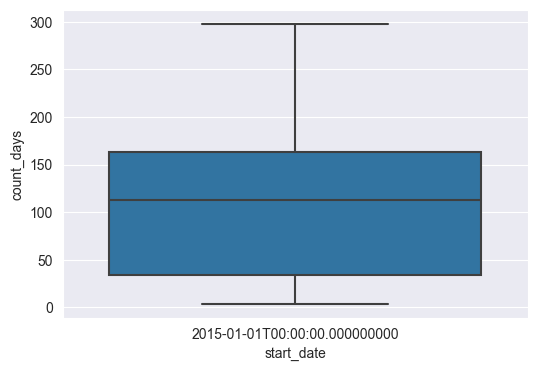

In [247]:
plt.figure(figsize=(6,4))
sns.boxplot(x= 'start_date',y='count_days',data=df_failured_record)
plt.show()

array([[<Axes: title={'center': 'count_days'}>,
        <Axes: title={'center': 'start_date'}>]], dtype=object)

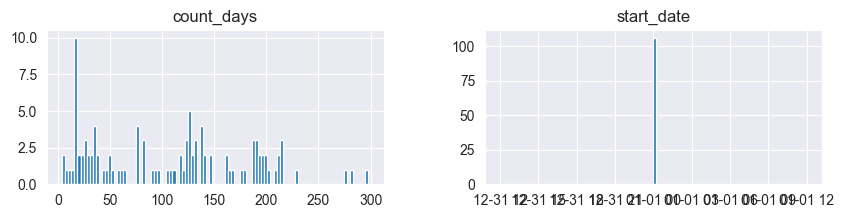

In [248]:
#Distribuição dos dispositivos que falharam em dias corrido a partir do inicio da monitoria de cada um
ax = df_failured_record.hist(bins=100, figsize=(10,2))
ax

In [249]:
df_failured_record.describe()

,count_days
count,106.000000
mean,106.905660
std,74.017826
min,4.000000
25%,34.000000
50%,113.000000
75%,163.250000
max,298.000000


In [250]:
#mediana
df_failured_record.mode()

,device,count_days,start_date,failure_date
0,S1F023H2,18.0,2015-01-01,2015-01-19
1,S1F03YZM,NaN,NaT,NaN
2,S1F09DZQ,NaN,NaT,NaN
3,S1F0CTDN,NaN,NaT,NaN
4,S1F0DSTY,NaN,NaT,NaN
...,...,...,...,...
101,Z1F1901P,NaN,NaT,NaN
102,Z1F1AG5N,NaN,NaT,NaN
103,Z1F1FCH5,NaN,NaT,NaN
104,Z1F1RJFA,NaN,NaT,NaN


In [251]:
#Falhas ranqueada por data
df_failured_record.groupby('failure_date')['device'].count().sort_values(ascending=False)

failure_date
2015-01-19    8
2015-05-08    3
2015-02-04    3
2015-07-20    2
2015-03-17    2
             ..
2015-04-20    1
2015-04-21    1
2015-04-27    1
2015-01-07    1
2015-10-26    1
Name: device, Length: 76, dtype: int64

Todos os dispositivos que falharam são monitorados desde o dia 01-01 e 75% deles falharam em até 163 dias após essa data.
O dia que mais dispositivos falharam aconteceu 18 dias após a data de inicio da monitoria, no total foram 8 dispositivos.
Vou utilizar essa janela de dias para fazer a Sobreamostragem e agregação dos dados dos sensores.

# Feature engineering

## Novas colunas auxiliares

In [252]:
#Esta é a janela pela qual será feita a agregação dos valores das colunas.
window = 18

In [253]:
#pegando o primeiro registro para cada máqui, com a coluna flipper
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,flipper,start_date
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1,2015-01-01
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,0,2015-01-01
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,0,2015-01-01
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,0,2015-01-01
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,0,2015-01-01


In [254]:
#Calcula o número de dias corridos para cada dispositivo até atingir 'window',
df['count_days'] = df['date'] - df['start_date']
df['time_since_start'] = df['count_days'] / np.timedelta64(1, 'D')
df = df.drop(columns=['count_days'])
# quando valor for 1, o histórico de monitoramento do dispositivo tem menos que 18 dias
df['too_soon'] = np.where((df.time_since_start < window) , 1, 0)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,flipper,start_date,time_since_start,too_soon
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1,2015-01-01,0.0,1
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,0,2015-01-01,1.0,1
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,0,2015-01-01,2.0,1
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,0,2015-01-01,3.0,1
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,0,2015-01-01,4.0,1


In [255]:
#Drop da coluna attribute8 por ter correlação perfeita positiva com a attribute9
df.drop('attribute8', axis=1, inplace=True)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,flipper,start_date,time_since_start,too_soon
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,1,2015-01-01,0.0,1
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,7,0,2015-01-01,1.0,1
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,7,0,2015-01-01,2.0,1
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,7,0,2015-01-01,3.0,1
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,7,0,2015-01-01,4.0,1


## Oversamplig - gerando mais casos de falha para balanceamento das classes

No primeiro momento vou testar a janela encontrada com a moda da coluna de datas para falhas

## Tranformação dos dados